In [2]:
!pip install matplotlib==3.3.4 -q

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [1969 lines of output]
      
      Edit setup.cfg to change the build options; suppress output with --quiet.
      
      BUILDING MATPLOTLIB
        matplotlib: yes [3.3.4]
            python: yes [3.11.5 (main, Sep 11 2023, 08:17:37) [Clang 14.0.6 ]]
          platform: yes [darwin]
       sample_data: yes [installing]
             tests: no  [skipping due to configuration]
            macosx: yes [installing]
      
      /Users/saisharankaram/miniconda3/lib/python3.11/site-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              *******

      ./builds/unix/libtool --mode=link gcc -o /private/var/folders/sz/_3gx0sl50tl9_hhxdwyl48sm0000gn/T/pip-install-z6gf1tn5/matplotlib_d89034400e2441b8a43596a707ad4eb3/build/freetype-2.6.1/objs/libfreetype.la  /private/var/folders/sz/_3gx0sl50tl9_hhxdwyl48sm0000gn/T/pip-install-z6gf1tn5/matplotlib_d89034400e2441b8a43596a707ad4eb3/build/freetype-2.6.1/objs/ftsystem.lo /private/var/folders/sz/_3gx0sl50tl9_hhxdwyl48sm0000gn/T/pip-install-z6gf1tn5/matplotlib_d89034400e2441b8a43596a707ad4eb3/build/freetype-2.6.1/objs/ftdebug.lo /private/var/folders/sz/_3gx0sl50tl9_hhxdwyl48sm0000gn/T/pip-install-z6gf1tn5/matplotlib_d89034400e2441b8a43596a707ad4eb3/build/freetype-2.6.1/objs/ftinit.lo /private/var/folders/sz/_3gx0sl50tl9_hhxdwyl48sm0000gn/T/pip-install-z6gf1tn5/matplotlib_d89034400e2441b8a43596a707ad4eb3/build/freetype-2.6.1/objs/ftbase.lo /private/var/folders/sz/_3gx0sl50tl9_hhxdwyl48sm0000gn/T/pip-install-z6gf1tn5/matplotlib_d89034400e2441b8a43596a707ad4eb3/build/freetype-2.6.1/objs/ftbbox

ERROR: Could not build wheels for matplotlib, which is required to install pyproject.toml-based projects


In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import math
import shutil
import warnings
import random
import dlib
import cv2
import pickle

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import *

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
warnings.filterwarnings('ignore')

In [5]:
# Path to the dataset directory
#change the Directory to dark, fair and middle based on the model to be trained
dataset_dir = '105_classes_pins_dataset'

In [6]:
# Function to load images from a given directory
def load_images_from_directory(directory):
    image_paths = []
    roots = []
    for root, _, files in os.walk(directory):
        if len(roots) <= 20:
            roots.append(root)
            for file in files:
                if file.endswith('.jpg'):
                    image_paths.append(os.path.join(root, file))
    return image_paths

In [7]:
# Load image paths from the dataset
image_paths = load_images_from_directory(dataset_dir)

In [8]:
# Display a random sample of images with celebrity names
def display_random_sample(image_paths, num_samples=5):
    random_sample = random.sample(image_paths, num_samples)
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(random_sample):
        celebrity = image_path.split('/')[1]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(celebrity.replace("pins_", ''))  # Display celebrity name as title
    plt.suptitle('Random Sample of Images from the Dataset', fontsize=16)
    plt.show()


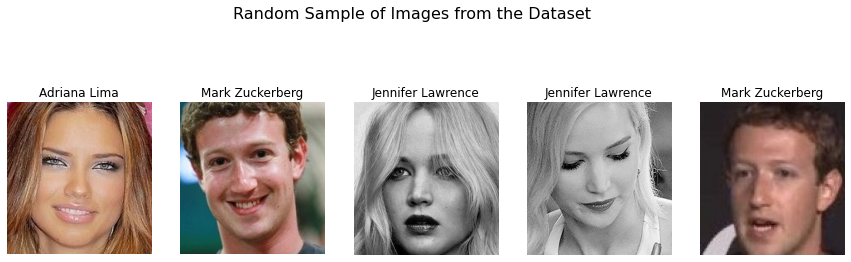

In [9]:
# Display a random sample of images with celebrity names
display_random_sample(image_paths)

In [10]:
# Count the number of images per celebrity
celeb_counts = {}
for image_path in image_paths:
    celebrity = image_path.split('/')[1]  # Extract celebrity name
    celebrity = celebrity.replace("pins_",'')
    celeb_counts[celebrity] = celeb_counts.get(celebrity, 0) + 1

# Sort the celebrities by the number of images they have
sorted_celebs = sorted(celeb_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 5 celebrities with the most images
top_5_celebs = sorted_celebs[:5]

# Extract celebrity names and image counts for the bar graph
celeb_names, image_counts = zip(*top_5_celebs)

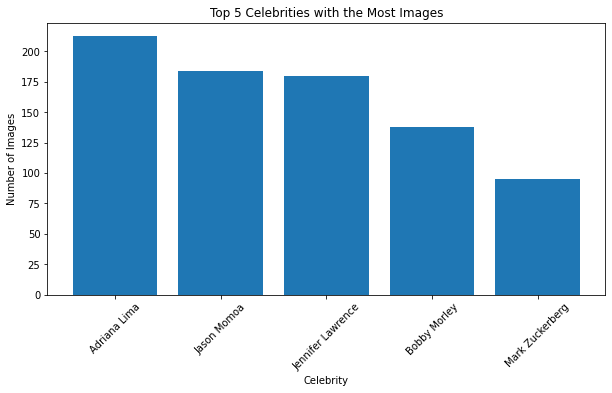

In [11]:
# Create a bar graph to show the top 5 celebrities with the most images
plt.figure(figsize=(10, 5))
plt.bar(celeb_names, image_counts)
plt.xlabel('Celebrity')
plt.ylabel('Number of Images')
plt.title('Top 5 Celebrities with the Most Images')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Get the dimensions of the dataset
num_images = len(image_paths)
image_shape = cv2.imread(image_paths[0]).shape

In [13]:
print(f"Number of Images in the Dataset: {num_images}")
print(f"Dimensions of Each Image: {image_shape}")


Number of Images in the Dataset: 810
Dimensions of Each Image: (184, 175, 3)


In [14]:
# Initialize the face detector and facial landmarks predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')  

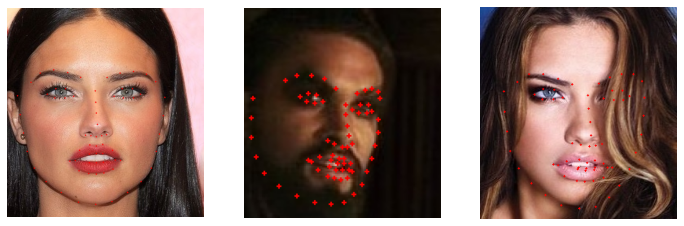

In [15]:
# Number of random samples to visualize
num_samples = 3

# Create a subplot grid for displaying images
fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

# Randomly select and visualize facial landmarks on sample images
for i in range(num_samples):
    # Randomly select an image
    random_image_path = random.choice(image_paths)

    # Load and process the selected image
    image = cv2.imread(random_image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector(gray)

    # Loop over detected faces and visualize facial landmarks
    for face in faces:
        landmarks = predictor(gray, face)
        landmarks = np.array([[landmarks.part(i).x, landmarks.part(i).y] for i in range(68)])

        # Draw landmarks on the image
        for (x, y) in landmarks:
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

    # Display the image with facial landmarks using Matplotlib
    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')

# Show the plotted images
plt.show()


In [16]:
# VGG Face model
model = Sequential()
# Block-1
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block-2
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block-3
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block-4
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block-5
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Fully connected layers
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))

# Flatten the output
model.add(Flatten())
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.load_weights('./models/vgg_face_weights.h5')

In [18]:
faceDescriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [19]:
# Initialize an empty array to store embeddings
num_samples = len(image_paths)
embedding_dim = 2622
embeddings = np.zeros((num_samples, embedding_dim))

# Loop through each image in the image_paths
for i, image_path in enumerate(image_paths):
    img_path = image_path
    
    # Load and preprocess the image
    img = cv2.imread(img_path, 1)
    img = img[..., ::-1]  # Convert from BGR to RGB
    img = (img / 255.).astype(np.float32)  # Normalize pixel values to [0, 1]
    img = cv2.resize(img, dsize=(224, 224))  # Resize the image to match model input size
    
    # Use the faceDescriptor model to extract embeddings
    embedding_vector = faceDescriptor.predict(np.expand_dims(img, axis=0))[0]
    
    # Store the embedding vector in the embeddings array
    embeddings[i] = embedding_vector

In [20]:
# Print the shape of the embeddings
print('Embeddings shape:', embeddings.shape)

Embeddings shape: (810, 2622)


In [21]:
# Calculate the Euclidean distance between embeddings of two images.

def euclidean_distance(emb1, emb2):
    # Check if the input arrays have the same shape
    if emb1.shape != emb2.shape:
        raise ValueError("Input arrays must have the same shape")

    # Calculate the squared differences element-wise
    squared_diff = np.square(emb1 - emb2)

    # Sum the squared differences to get the Euclidean distance
    distance = np.sqrt(np.sum(squared_diff))

    return distance

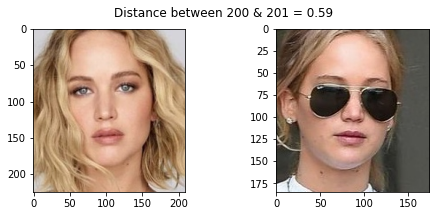

In [26]:
idx1 = 200
idx2 = 201

plt.figure(figsize=(8, 3))
plt.suptitle(f'Distance between {idx1} & {idx2} = {euclidean_distance(embeddings[idx1], embeddings[idx2]):.2f}')

plt.subplot(121)
plt.imshow(cv2.imread(image_paths[idx1], 1)[..., ::-1])

plt.subplot(122)
plt.imshow(cv2.imread(image_paths[idx2], 1)[..., ::-1])
plt.show()

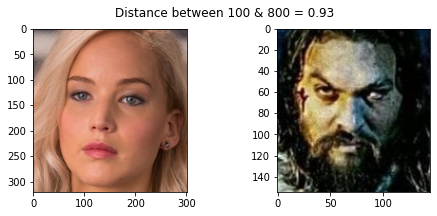

In [29]:
idx1 = 100
idx2 = 800

plt.figure(figsize=(8, 3))
plt.suptitle(f'Distance between {idx1} & {idx2} = {euclidean_distance(embeddings[idx1], embeddings[idx2]):.2f}')

plt.subplot(121)
plt.imshow(cv2.imread(image_paths[idx1], 1)[..., ::-1])

plt.subplot(122)
plt.imshow(cv2.imread(image_paths[idx2], 1)[..., ::-1])
plt.show()


In [30]:
labels = [image_path.split('/')[1].replace("pins_",'') for image_path in image_paths]
print(len(labels))

810


In [33]:
# splititng the data for train and test
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.1)

In [35]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(np.array(y_train).shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(np.array(y_test).shape[0]))

X_train shape : (729,2622)
y_train shape : (729,)
X_test shape : (81,2622)
y_test shape : (81,)


In [38]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels in y_train and y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [40]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training features (X_train)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [41]:
# Reduce dimensions using PCA
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_std shape : (729,2622)
y_train_encoded shape : (729,)
X_test_std shape : (81,2622)
y_test_encoded shape : (81,)


In [43]:
# Initialize PCA with the desired number of components (128 in this case)
pca = PCA(n_components=128)

# Fit and transform the standardized training features (X_train_std)
X_train_pca = pca.fit_transform(X_train_std)

# Transform the standardized test features (X_test_std) using the same PCA transformation
X_test_pca = pca.transform(X_test_std)

In [68]:
# Machine Learning Classifier
# Initialize the Support Vector Classifier with specified hyperparameters (C and gamma)
clf = SVC(C=5.0, gamma=0.001, probability=True)

In [69]:
# Fit the classifier to the training data with PCA-transformed features
clf.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001, probability=True)

In [70]:
# Make predictions on the test data using the trained classifier
y_predict = clf.predict(X_test_pca)

In [71]:
y_predict

array([0, 1, 3, 0, 1, 3, 2, 0, 3, 0, 3, 4, 1, 0, 2, 2, 1, 0, 1, 3, 0, 1,
       0, 3, 0, 0, 2, 1, 2, 2, 4, 0, 4, 0, 2, 3, 0, 0, 0, 1, 0, 2, 2, 3,
       2, 2, 4, 4, 2, 1, 1, 0, 3, 1, 3, 2, 3, 0, 2, 3, 2, 3, 2, 3, 0, 1,
       1, 3, 2, 2, 0, 3, 1, 0, 3, 0, 2, 3, 2, 2, 2])

In [72]:
y_test_encoded

array([0, 1, 3, 0, 1, 3, 2, 0, 3, 0, 3, 4, 1, 0, 2, 2, 1, 0, 1, 3, 0, 1,
       0, 3, 0, 0, 2, 1, 2, 2, 4, 0, 4, 0, 2, 3, 0, 0, 0, 1, 0, 2, 2, 3,
       2, 2, 4, 4, 2, 1, 1, 0, 3, 1, 3, 2, 3, 0, 2, 3, 2, 3, 2, 3, 0, 1,
       1, 3, 2, 2, 0, 3, 1, 0, 3, 0, 2, 3, 2, 2, 2])

In [73]:
# Calculate accuracy score
accuracy = accuracy_score(y_test_encoded, y_predict)

# Calculate precision for each class
precision = precision_score(y_test_encoded, y_predict, average='weighted')

# Generate a classification report
classification_rep = classification_report(y_test_encoded, y_predict)

In [74]:
# Print the results
print("Accuracy:", accuracy)
print("Precision (weighted):", precision)
print("Classification Report:\n", classification_rep)

Accuracy: 1.0
Precision (weighted): 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00         5

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



In [87]:
# Load and preprocess the test image
img = cv2.imread(image_paths[41], 1)
img = img[..., ::-1]  # Convert from BGR to RGB
img = (img / 255.).astype(np.float32)  # Normalize pixel values to [0, 1]
img = cv2.resize(img, dsize=(224, 224))  # Resize the image to match model input size
    
# Use the faceDescriptor model to extract embeddings
embedding_vector = faceDescriptor.predict(np.expand_dims(img, axis=0))[0]

In [88]:
scaledData = scaler.transform([embedding_vector])
pcaData = pca.transform(scaledData)

In [89]:
predictedLabel = clf.predict(pcaData)
predictedScore = clf.predict_proba(pcaData)

In [90]:
celebrityName = label_encoder.inverse_transform(predictedLabel)

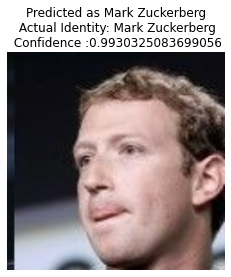

In [96]:
# Get the prediction and identity for the example
example_prediction = celebrityName[0]
example_identity = labels[41]

# Display the example image with a title
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted as {example_prediction}\n Actual Identity: {example_identity}\n Confidence :{max(predictedScore[0])}')
plt.show()


In [100]:
# save the neccessary model files 
faceDescriptor.save("./models/vggModel.pkl")
pickle.dump(scaler, open("./models/scaler.pkl", "wb"))
pickle.dump(pca, open("./models/pca.pkl", "wb"))
pickle.dump(clf, open("./models/svmModel.pkl", "wb"))
pickle.dump(label_encoder, open("./models/label_encoder.pkl", "wb"))

In [9]:
vgg = load_model("./models/vggModel.pkl")
scaler = pickle.load(open("./models/scaler.pkl", 'rb'))
pca = pickle.load(open("./models/pca.pkl", 'rb'))
svm = pickle.load(open("./models/svmModel.pkl", 'rb'))
le = pickle.load(open("./models/label_encoder.pkl", 'rb'))

In [10]:
img = cv2.imread("105_classes_pins_dataset/pins_Mark Zuckerberg/Mark Zuckerberg1_1990.jpg", 1)
img = img[..., ::-1] 
img = (img / 255.).astype(np.float32)  
img = cv2.resize(img, dsize=(224, 224)) 

In [11]:
embedding_vector = vgg.predict(np.expand_dims(img, axis=0))[0]
scaledData = scaler.transform([embedding_vector])
pcaData = pca.transform(scaledData)
predictedLabel = svm.predict(pcaData)
predictedScore = svm.predict_proba(pcaData)
celebrityName = le.inverse_transform(predictedLabel)

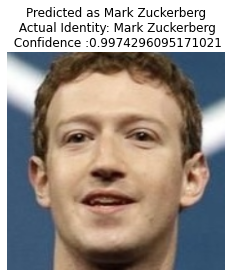

In [12]:
# Get the prediction and identity for the example
example_prediction = celebrityName[0]
example_identity = "Mark Zuckerberg"

# Display the example image with a title
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted as {example_prediction}\n Actual Identity: {example_identity}\n Confidence :{max(predictedScore[0])}')
plt.show()
